validationデータの用意
validation処理の追加

In [22]:
import os

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# 訓練データをdatasetsからダウンロード
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# テストデータをdatasetsからダウンロード
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Subsetを用いて、もともとの学習用画像60000枚を学習用50000枚と検証用10000枚に分割

In [4]:
train_size = 50000
train_indices = list(range(0,train_size))
valid_indices = list(range(train_size, len(training_data)))
train_data = Subset(training_data, train_indices)
valid_data = Subset(training_data, valid_indices)

print(len(train_data), len(valid_data))


50000 10000


In [5]:
batch_size = 64

# データローダーの作成
train_dataloader = DataLoader(train_data, batch_size=batch_size)
validation_dataloader = DataLoader(valid_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# modelを定義します
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [15]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    epoch_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # 損失誤差を計算
        pred = model(X)
        loss = loss_fn(pred, y)
        epoch_loss += loss.item()
        # バックプロパゲーション
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]") #表示している損失はバッチ全体の損失
    epoch_loss /= size
    return epoch_loss

In [16]:
def validation(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    validation_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            validation_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    validation_loss /= size
    correct /= size
    print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {validation_loss:>8f} \n")
    return validation_loss

In [28]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    test_predictions = []
    test_labels = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            test_predictions.extend(pred.argmax(1).cpu().tolist())
            test_labels.extend(y.cpu().tolist())
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    results = {"label": test_labels, "prdiction": test_predictions}
    df = pd.DataFrame(results)
    return df

validation損失をもとに最適epochを決定


In [18]:
epochs = 5
min_loss = 1000
model_path = "model/nn/"
result_dir = "result/"

os.makedirs(model_path, exist_ok=True)
os.makedirs(result_dir, exist_ok=True)

train_losses = []
validation_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)
    validation_loss = validation(validation_dataloader, model)
    validation_losses.append(validation_loss)
    if validation_loss < min_loss:
        best_epoch = t+1
        min_loss = validation_loss
    torch.save(model.state_dict(), model_path+"model_"+str(t+1)+".pth")

model = NeuralNetwork().to(device)
model.load_state_dict(torch.load(model_path+"model_"+str(best_epoch)+".pth"))
df_label_pred = test(test_dataloader, model)
df_label_pred.to_csv(result_dir+"test_nn.csv")

print(best_epoch)
print("Done!")

Epoch 1
-------------------------------
loss: 2.296173  [    0/50000]
loss: 2.294875  [ 6400/50000]
loss: 2.288735  [12800/50000]
loss: 2.287077  [19200/50000]
loss: 2.267018  [25600/50000]
loss: 2.231493  [32000/50000]
loss: 2.246675  [38400/50000]
loss: 2.216201  [44800/50000]
Validation Error: 
 Accuracy: 38.8%, Avg loss: 0.034898 

Epoch 2
-------------------------------
loss: 2.209831  [    0/50000]
loss: 2.219833  [ 6400/50000]
loss: 2.199665  [12800/50000]
loss: 2.229494  [19200/50000]
loss: 2.176646  [25600/50000]
loss: 2.111465  [32000/50000]
loss: 2.157998  [38400/50000]
loss: 2.097040  [44800/50000]
Validation Error: 
 Accuracy: 46.3%, Avg loss: 0.033317 

Epoch 3
-------------------------------
loss: 2.097657  [    0/50000]
loss: 2.118371  [ 6400/50000]
loss: 2.082383  [12800/50000]
loss: 2.149711  [19200/50000]
loss: 2.040035  [25600/50000]
loss: 1.945649  [32000/50000]
loss: 2.029123  [38400/50000]
loss: 1.930940  [44800/50000]
Validation Error: 
 Accuracy: 47.4%, Avg los

RuntimeError: a Tensor with 64 elements cannot be converted to Scalar

損失グラフ作成

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


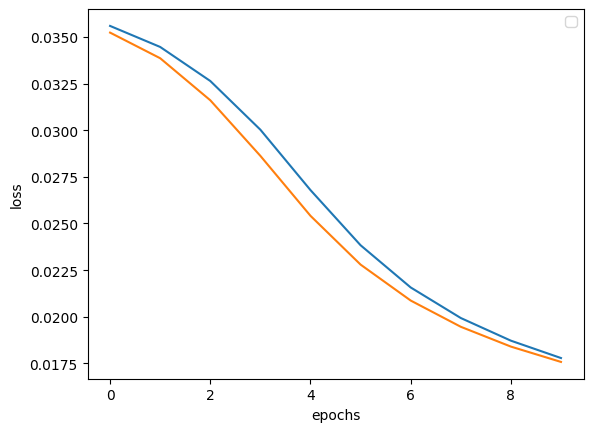

In [ ]:
plt.plot(train_losses, label="train")
plt.plot(validation_losses, label="validataion")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()
